In [28]:
import numpy as np
import optimisation as opt
import estimation_environment as est
import importlib
importlib.reload(opt)
importlib.reload(est)

<module 'estimation_environment' from '/Users/krzywdaja/Documents/obsedian_test/Brain2/Science/Projects/Estimation-AI/Code/estimation_environment.py'>

## Open AI gym


In [12]:

import numpy as np
# Load the TensorBoard notebook extension
%load_ext tensorboard
import matplotlib.pyplot as plt


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
cs = np.arange(2,12)
print(cs)
om0 = 0
sigma  = 50
initial_std = 10
seed_environment =  1
seed_estimation = 2


def policy_est(state, **kwargs):
    action = kwargs["rng_est"].choice([0,1,2],p=[1/3,1/3,1/3])
    return action



env = est.EstimationEnv(length = 50, tc =50, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= None, seed_field = None)



rng2 = np.random.default_rng(seed_estimation)
res = opt.game(episodes = 10, model=None, env=env, policy = policy_est, rng_est = rng2)

[ 2  3  4  5  6  7  8  9 10 11]


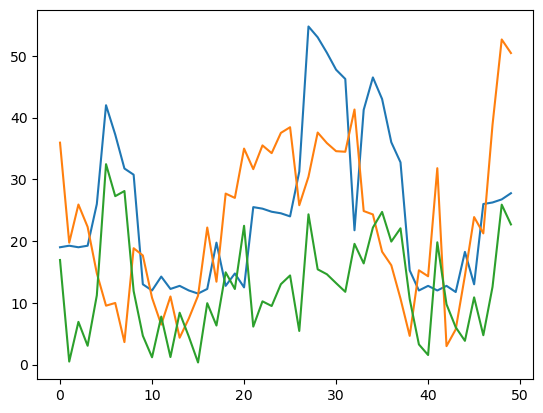

In [14]:
plt.plot(np.abs(np.array(res.mus[0])))
plt.plot(np.abs(np.array(res.oms[0])))
plt.plot(res.get_error()[0])

In [19]:
import gymnasium as gym
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=100000,
  save_path="./logs/",
  name_prefix="rl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

# Parallel environments
logdir = "./ppo_bayes_tensorboard2/"
om0 =0 
tcs = [50]
seed_environment = 1


for c in cs:
    env = est.NoCheck(length = 1000, tc = 1000, c=c, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= None, seed_field = None)
    if not os.path.exists("./ppo_bayes_tensorboard2/"):
        os.makedirs("./ppo_bayes_tensorboard2/")

    checkpoint_callback = CheckpointCallback(
    save_freq=100000,
    save_path="./logs/",
    name_prefix="rl_model",
    save_replay_buffer=True,
    save_vecnormalize=True,
    )
    env = Monitor(env, logdir, allow_early_resets=True)
    eval_callback = EvalCallback(env, best_model_save_path="./logs"+str(c)+"/",
                             log_path="./logs"+str(c)+"/", eval_freq=5000,
                             deterministic=False, render=False, n_eval_episodes=10)

    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_bayes_tensorboard2/")
    model.learn(total_timesteps=100000, reset_num_timesteps=False, tb_log_name="PPO", callback=eval_callback)
    model.save("ppo_"+str(c))

    


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_bayes_tensorboard2/PPO_0


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 88       |
| time/              |          |
|    fps             | 616      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 183         |
| time/                   |             |
|    fps                  | 566         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013111528 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | 0.00311     |
|    learning_rate        | 0.

In [ ]:
%tensorboard --logdir ppo_bayes_tensorboard2 --port 6010

Reusing TensorBoard on port 6010 (pid 1137), started 0:00:04 ago. (Use '!kill 1137' to kill it.)

In [29]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
games = []
means = []
for c in cs:
    model = model.load("logs"+str(c)+"/best_model.zip")
    # wrap env with monito
    env = est.NoCheck(length = 1000, tc = 1000, c=c, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= None, seed_field = None)
    res = opt.game(episodes = 5, model=model, env=env)
    games.append(np.sum(res.rewards,axis=1))    
    

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

(174.8, 35.95775298875056)

In [ ]:
menas = [np.average(val[k][0]) for k in range(len(val))]
stds = [np.std(val[k][0]) for k in range(len(val))]

<ErrorbarContainer object of 3 artists>

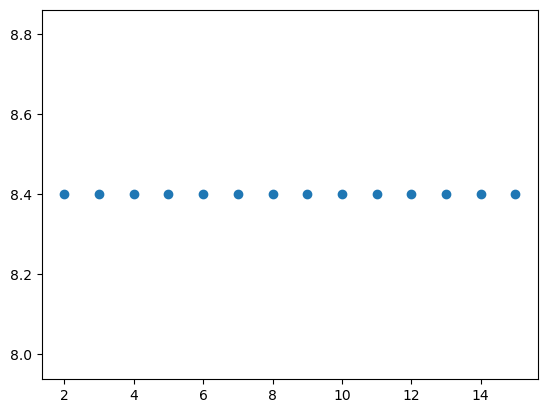

In [ ]:
plt.errorbar(cs, menas, yerr=stds, fmt='o')

# Plot the reward for N=100

In [ ]:
import gymnasium as gym
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env


results = []
for tcn,tc in enumerate(tcs):
    print(tc)
    model.load("logs/best_model.zip")
    env = est.EstimationEnv(length = int(1000), tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= seed_environment, seed_field = seed_environment)
    results.append(opt.game(episodes = 100, model=model, env=env))

50


In [ ]:
results_sum = [np.sum(results[k].rewards,axis=1) for k in range(1)]

In [ ]:
results.append(opt.game(episodes = 2, model=model, env=env))

([<matplotlib.axis.XTick at 0x7fb2bc732bf0>], [Text(1, 0, '50')])

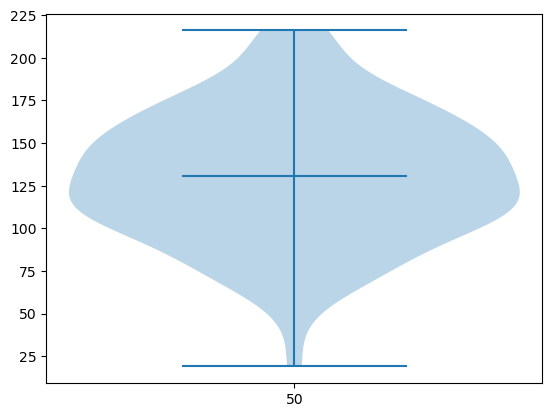

In [ ]:

plt.violinplot(np.array(results_sum).T, showmeans=True)
plt.xticks(np.arange(len(tcs))+1, tcs)

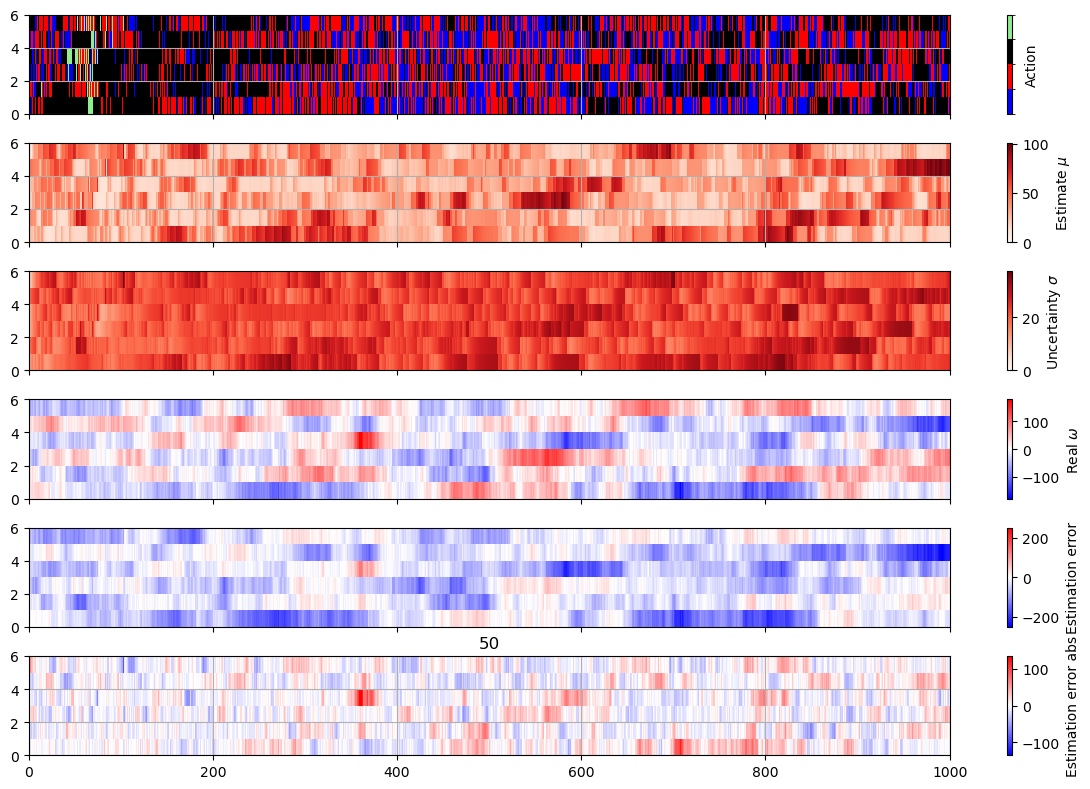

In [ ]:


tcsn = 0
for tc in tcs:


    samples = 6
    model.load("logs/best_model")
    env = est.EstimationEnv(length = int(1e3), tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                        seed_shot= seed_environment, seed_field = seed_environment)

    results = opt.game(episodes = samples, model=model, env=env)
    
    est.analyse_few_games(results, str(tc))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


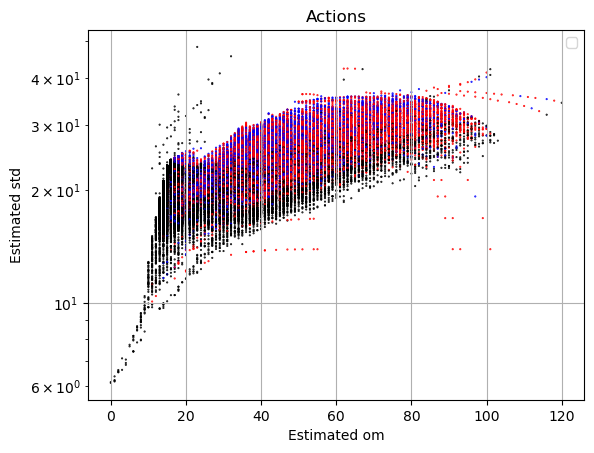

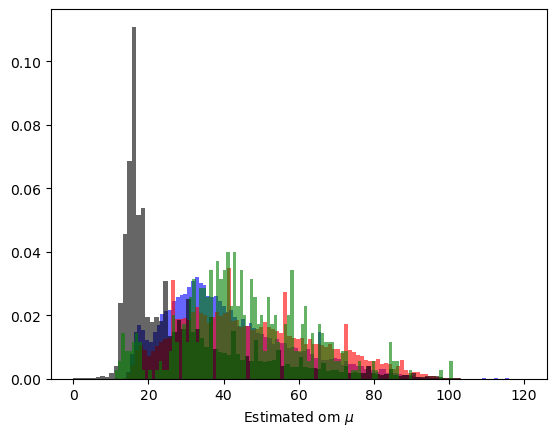

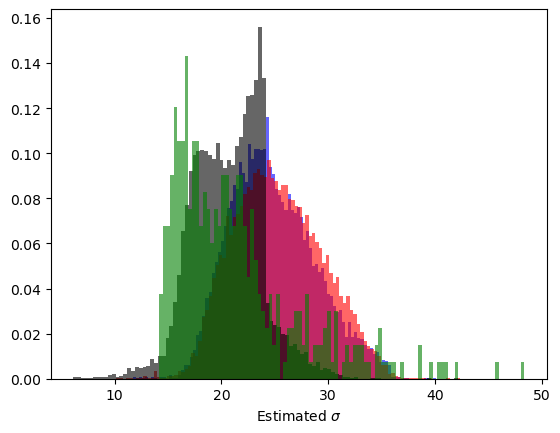

In [ ]:
for tc in tcs:


    samples = 50
    model.load("logs/best_model")
    env = est.EstimationEnv(length = int(1e3), tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                        seed_shot= seed_environment, seed_field = seed_environment)

    results = opt.game(episodes = samples, model=model, env=env)

    est.analyse_decisions(results, str(tc))



In [ ]:
env.tc

50

In [ ]:

policies = opt.policy_random_p, opt.policy_max_std, opt.policy_min_mu, opt.policy_interval
bounds = [np.array([[0,1],[0,1],[0,1]]),
            np.array([[0,10],[0,1]]),
            np.array([[0,100],[0,1]]),
            np.array([[0,100],[0,100],[0,100]])]
sigmas = [np.array(0.5), np.array(50.), np.array(50.), np.array(50.)]
means = [np.array([0.7,0.2,0.1]), np.array([5.,0.5]), np.array([50.,0.2]), np.array([50.,10.,2.])]


xs = []
for tc in tcs:
    xs_tc = []
    for pn,policy in enumerate(policies):
            print(bounds[pn])
            print(sigmas[pn])
            print(means[pn])
            env = est.EstimationEnv(length = 1000, tc = tc, om0=om0, sigma = sigma, initial_std=initial_std,
                            seed_field = 1, seed_shot = 1)
            Opt = opt.CMA_optimizer(policy = policies[pn], 
                            generations = 5, 
                            population_size=10, 
                            bounds = bounds[pn], 
                            sigma = sigmas[pn], 
                            mean= means[pn], 
                            episodes = 5,
                            env=env)
            sol = Opt.optimize()
            x_avg, f_avg = Opt.get_representative()
            xs_tc.append(x_avg)
    xs.append(xs_tc)
    

[[0 1]
 [0 1]
 [0 1]]
0.5
[0.7 0.2 0.1]
0
1
2
3
4
[[ 0 10]
 [ 0  1]]
50.0
[5.  0.5]
0
1
2
3
4
[[  0 100]
 [  0   1]]
50.0
[50.   0.2]
0
1
2
3
4
[[  0 100]
 [  0 100]
 [  0 100]]
50.0
[50. 10.  2.]
0
1
2
3
4
[[0 1]
 [0 1]
 [0 1]]
0.24510910926232096
[0.7 0.2 0.1]
0
1
2
3
4
[[ 0 10]
 [ 0  1]]
16.8765895662817
[5.  0.5]
0
1
2
3
4
[[  0 100]
 [  0   1]]
11.521377805929335
[50.   0.2]
0
1
2
3
4
[[  0 100]
 [  0 100]
 [  0 100]]
27.19805165374456
[50. 10.  2.]
0
1
2
3
4
[[0 1]
 [0 1]
 [0 1]]
0.12123165316833177
[0.7 0.2 0.1]
0
1
2
3
4
[[ 0 10]
 [ 0  1]]
6.086106317015185
[5.  0.5]
0
1
2
3
4
[[  0 100]
 [  0   1]]
8.734860890349436
[50.   0.2]
0
1
2
3
4
[[  0 100]
 [  0 100]
 [  0 100]]
19.001944550417758
[50. 10.  2.]
0
1
2
3
4
[[0 1]
 [0 1]
 [0 1]]
0.0690636694038529
[0.7 0.2 0.1]
0
1
2
3
4
[[ 0 10]
 [ 0  1]]
4.1690743137402295
[5.  0.5]
0
1
2
3
4
[[  0 100]
 [  0   1]]
3.8356570135950756
[50.   0.2]
0
1
2
3
4
[[  0 100]
 [  0 100]
 [  0 100]]
10.358498476466856
[50. 10.  2.]
0
1
2
3
4
[[0 

In [ ]:
#save nested xs list to file
import pickle
with open('xs.pkl', 'wb') as f:
    pickle.dump(xs, f)


In [ ]:
#load nested xs list from file
import pickle
with open('xs.pkl', 'rb') as f:
    xs = pickle.load(f)


In [ ]:
xs

[[array([0.73117156, 0.4093704 , 0.02254516]),
  array([6.02575545, 0.51700893]),
  array([55.43331841,  0.70820324]),
  array([46.3830937 , 13.06998139,  3.46838991])],
 [array([0.75365769, 0.24433546, 0.01646223]),
  array([5.81209298, 0.39922085]),
  array([49.21792449,  0.93059551]),
  array([49.83677335,  6.28488514,  0.66992279])],
 [array([0.72633717, 0.17840917, 0.00897916]),
  array([4.94913091, 0.53521408]),
  array([49.40604232,  0.63984954]),
  array([47.68936452,  9.4728695 ,  0.5825536 ])]]

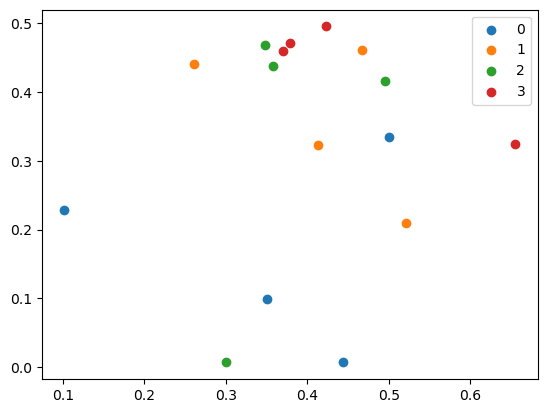

In [ ]:
sol[:,:,:3] = sol[:,:,:3]/np.sum(sol[:,:,:3],axis=2)[...,None]
for k in range(4):
    plt.scatter(sol[k,:,0], sol[k,:,1], label = str(k))
plt.legend()

In [ ]:
import numpy as np
import optimisation as opt
import estimation_environment as est
import importlib
importlib.reload(opt)
importlib.reload(est)
policies = 7
'''
-always flip
-random
-random with flip p =0.8, est p = 0.15, check p = 0,5
-flip only if std/mu below 0.5
-flip only if mu is above 10
-estimate 5 shots every 30 shots
-agent
'''





#model = model.load("ppo_bayes2")
tcs = [50,100,250,500,1000]
samples = 25

policies_all = opt.policy_flip, opt.policy_random, opt.policy_random_p, opt.policy_max_std, opt.policy_min_mu, opt.policy_interval

tot_reward = np.zeros((len(tcs),len(policies_all)+1,samples))

for tcn, tc in enumerate(tcs):
    print(tc)
    model.load("ppo_N1e3_check_"+str(tc))
    
    for pn,policy in enumerate(policies_all):
        
        env = est.EstimationEnv(length = 1000, tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= seed_environment, seed_field = seed_environment)
        if pn>1:
            results = opt.game(episodes = samples, policy=policies_all[pn], env=env, x = xs[tcn][pn-2], rng_est = np.random.default_rng(seed_estimation))
            tot_reward[tcn,pn,:] = np.sum(results.rewards,axis=1)
        else:
            results = opt.game(episodes = samples, policy=policies_all[pn], env=env, rng_est = np.random.default_rng(seed_estimation))
            tot_reward[tcn,pn,:] = np.sum(results.rewards,axis=1)
    
    env = est.EstimationEnv(length = 1000, tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= seed_environment, seed_field = seed_environment)
    results = opt.game(episodes = samples, model=model, env=env)
    tot_reward[tcn,-1,:] =  np.sum(results.rewards,axis=1)

50
100
250
500
1000


In [ ]:
tcs

[100, 200, 300]

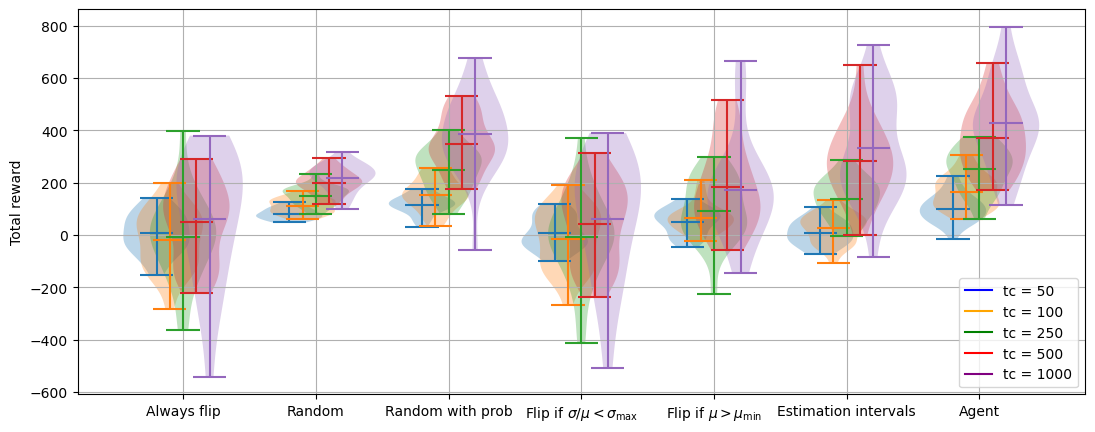

In [ ]:
#compare rewards using different policies via violin plot
plt.figure(figsize=(13,5))
tcs = [50,100,250,500,1000]
for tcn,tc in enumerate(tcs):
    plt.violinplot(tot_reward[tcn].T, showmeans=True, positions=np.arange(1,8)-.2+tcn*0.1, widths=0.5)
plt.xticks(np.arange(1,8),["Always flip","Random","Random with prob",r"Flip if $\sigma/\mu<\sigma_\text{max}$",r"Flip if $\mu>\mu_\text{min}$",
                            "Estimation intervals","Agent"])
plt.ylabel("Total reward")
#plt.ylim(-200,550)
plt.grid()
plt.plot([],[],color = "blue", label="tc = 50")
plt.plot([],[],color = "orange", label="tc = 100")
plt.plot([],[],color = "green", label="tc = 250")
plt.plot([],[],color = "red", label="tc = 500")
plt.plot([],[],color = "purple", label="tc = 1000")

plt.legend(loc="lower right")


<Figure size 1300x500 with 0 Axes>

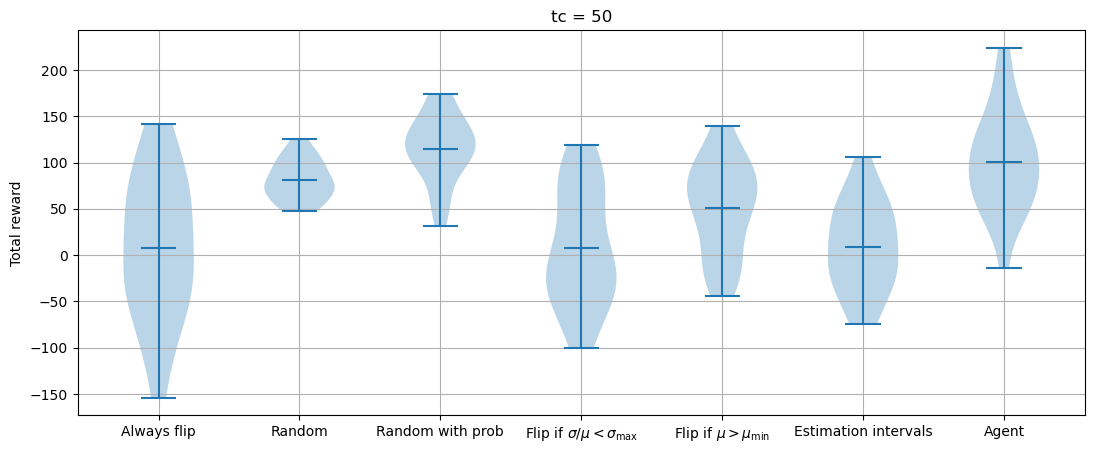

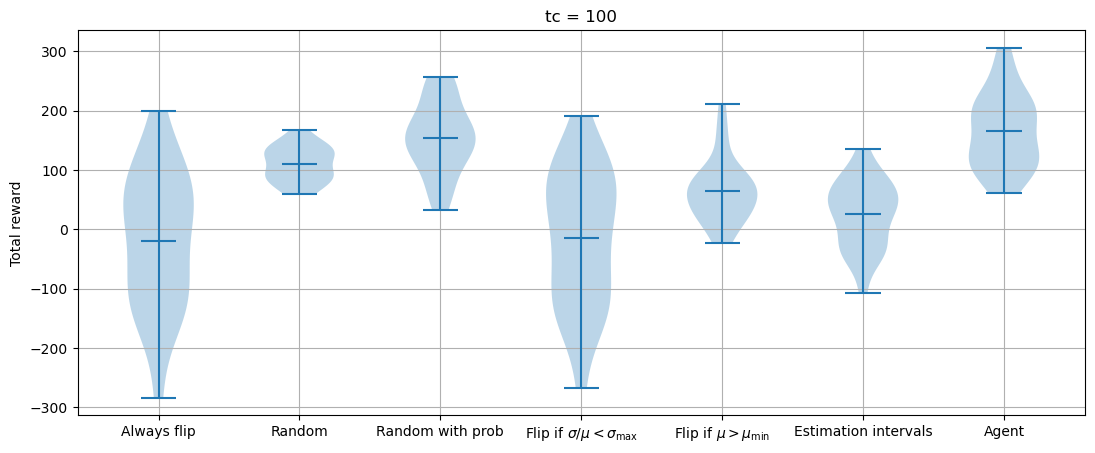

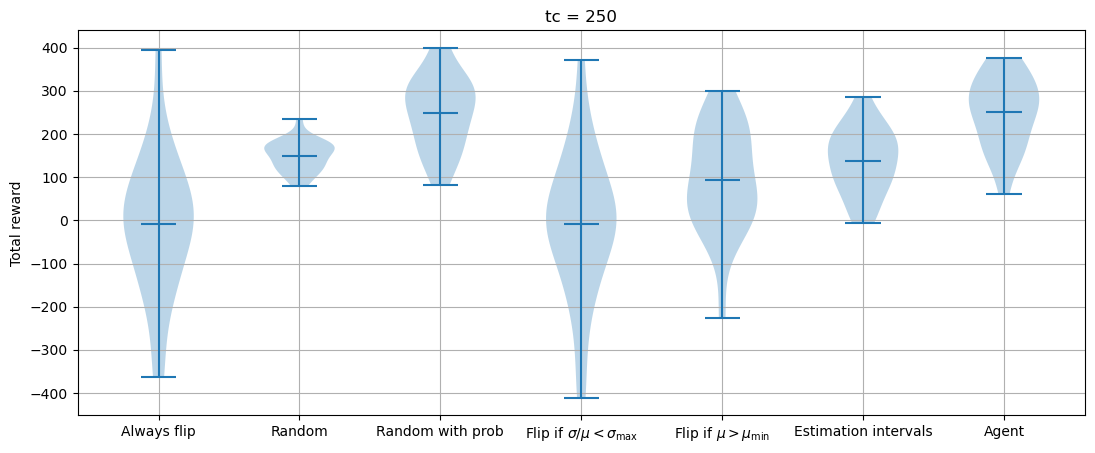

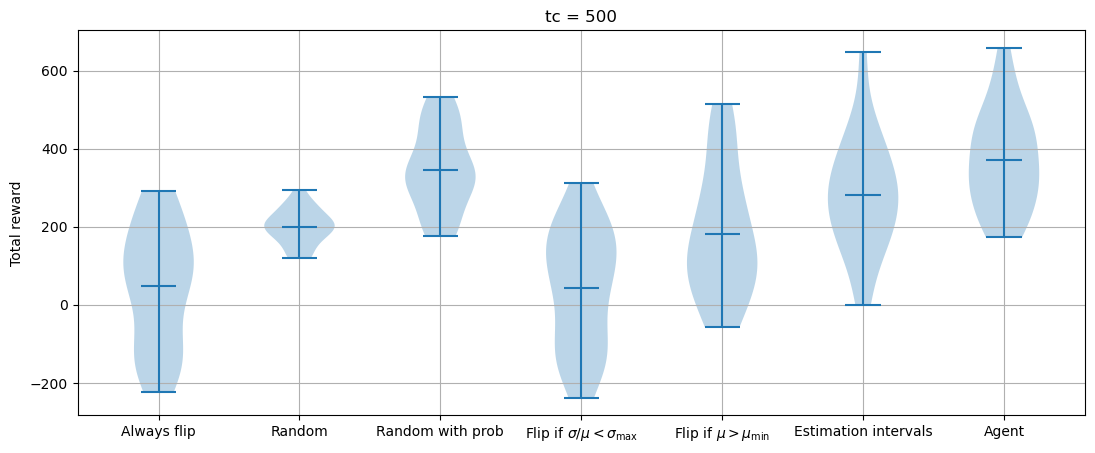

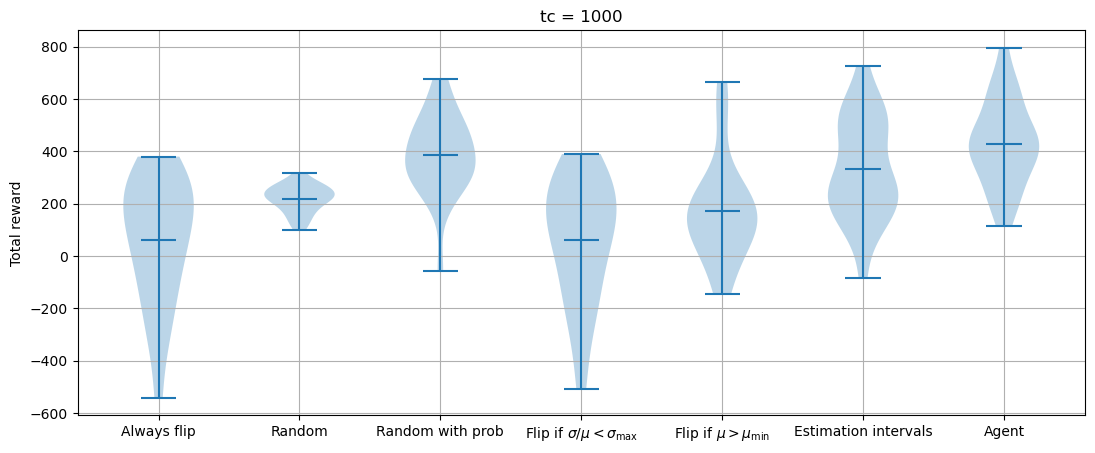

In [ ]:
#compare rewards using different policies via violin plot
plt.figure(figsize=(13,5))
for tcn,tc in enumerate(tcs):
    plt.figure(figsize=(13,5))
    plt.violinplot(tot_reward[tcn].T, showmeans=True, positions=np.arange(1,8), widths=0.5)
    plt.xticks(np.arange(1,8),["Always flip","Random","Random with prob",r"Flip if $\sigma/\mu<\sigma_\text{max}$",r"Flip if $\mu>\mu_\text{min}$",
                                "Estimation intervals","Agent"])
    plt.ylabel("Total reward")
    plt.grid()
    plt.title("tc = "+str(tc))
    #plt.ylim(-200,550)
plt.plot([],[],color = "blue", label="tc = 50")
plt.plot([],[],color = "orange", label="tc = 500")
plt.plot([],[],color = "green", label="tc = 5000")
#plt.legend(loc="lower right")